# FOREX Price Prediction with LSTM model

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

plt.style.use('seaborn-v0_8-whitegrid')

## Data Load

In [ ]:
raw_data = yf.download(tickers='EURUSD=X', start='2011-12-31', end='2019-12-31', interval='1d')
raw_data.columns = raw_data.columns.droplevel(1)
raw_data

[*********************100%***********************]  1 of 1 completed


Price,Adj Close,Close,High,Low,Open,Volume
Date,,,,,,
2012-01-02,1.296008,1.296008,1.296395,1.292257,1.296008,0
2012-01-03,1.294096,1.294096,1.306592,1.293628,1.293628,0
2012-01-04,1.305602,1.305602,1.307395,1.290206,1.305398,0
2012-01-05,1.293142,1.293142,1.294297,1.278527,1.293092,0
2012-01-06,1.279607,1.279607,1.281296,1.270406,1.279296,0
...,...,...,...,...,...,...
2019-12-24,1.109385,1.109385,1.109755,1.107064,1.109299,0
2019-12-25,1.109016,1.109016,1.110864,1.107788,1.109139,0
2019-12-26,1.109545,1.109545,1.110494,1.108279,1.109509,0


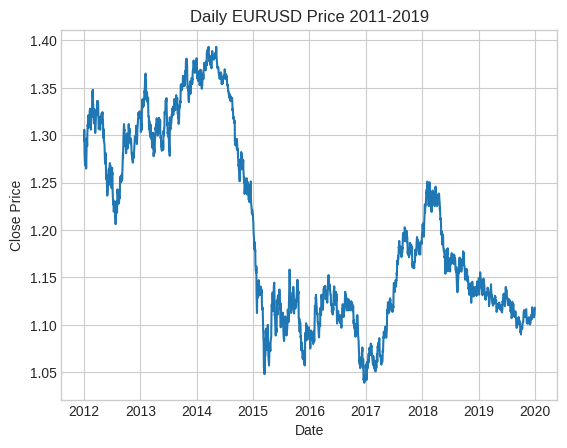

In [ ]:
plt.plot(raw_data.index, raw_data.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily EURUSD Price 2011-2019')
plt.show()

## Implement class and function

In [115]:
class Utils:

  @staticmethod
  def data_split(data, train_size = 0.7):
    '''
    Split dataset into train_data and val_data

    Prameters:
    - data (pd.Dataframe) : input dataframe
    - train_size (float): The ratio of train dataset. Default is 0.7

    Return:
    - train_data: train dataframe
    - val_data: validation dataframe

    '''
    train_data = data[:math.ceil(len(data)*train_size)]
    val_data = data[math.ceil(len(data)*train_size):]

    return train_data, val_data

  @staticmethod
  def data_scaling(data, scaler=MinMaxScaler(feature_range=(-1,1)), train=True):
    '''
    Feature scaling transforms feature values to a similar scale, ensuring all features contribute equally to the model.

    Parameters:
    - data (pd.Dataframe): array-like of shape (n_samples, n_features)
    - scaler (ojb): scikit-learn scaler. Default is MinMaxScaler(feature_range=(-1,1)))

    Return:
    - scaled_data (np.array): scaled data
    - scaler (ojb): scaler object
    '''
    if train:
      scaled_data = scaler.fit_transform(data)

    else:
      scaled_data = scaler.transform(data)

    return scaled_data, scaler


  @staticmethod
  def prepare_sequence_input_target(data, look_back):
    '''
    Prepare input sequences and corresponding target values.

    This function creates input sequences of a specified window size and their corresponding target values.

    Parameters:
    - data (np.array): array-like of shape (n_samples, n_features)
    - look_back (int): The length of input sequences.

    Return:
    - X_train (np.array): Input sequences of shape (n_samples, look_back, n_features)
    - y_train (np.array): Target values of shape (n_samples, n_features)
    '''
    X_train, y_train = [], []
    for i in range(look_back, len(data)):
      X_train.append(data[i-look_back:i,:])
      y_train.append(data[i,:])

    return np.array(X_train), np.array(y_train)


def process_sequence_data(data, look_back, scaler, train):

    scaled_data, scaler  = Utils.data_scaling(data, scaler, train)
    X, y = Utils.prepare_sequence_input_target(scaled_data, look_back)
    dataset = MyDataset(X, y)

    return dataset, scaler


In [3]:
class MyDataset(Dataset):

  def __init__(self, X, y):
    self.X = torch.tensor(X, dtype=torch.float32)
    self.y = torch.tensor(y, dtype=torch.float32)

  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    X = self.X[idx]
    y = self.y[idx]

    return X, y

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size=1, hidden_size=32, num_layers=1, output_size=1, dropout=0):
    super().__init__()
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
    self.fc = nn.Linear(hidden_size, output_size)

  def forward(self, x):

    output, self.hidden_cell = self.lstm(x)
    predictions = self.fc(output[:,-1,:]) # [batch_size, output_size]

    return predictions[:, 0]

In [64]:
def train(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path):
  train_loss_log = {}
  val_loss_log = {}
  best_val_loss = np.inf

  for epoch in range(1, epochs+1):

    # model training
    model.train()
    train_loss = 0
    for batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
      X, y = data
      X = X.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      # y_pred = model(X).view(1,1)
      y_pred = model(X)
      loss = criterion(y_pred, y)

      # import pdb; pdb.set_trace()

      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # model validation
    model.eval()
    val_loss = 0

    for batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
      X_val, y_val = data
      X_val = X_val.to(device)
      y_val = y_val.to(device)


      # y_val_pred = model(X_val).view(1,1)
      y_val_pred = model(X_val)
      loss = criterion(y_val_pred, y_val)

      val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_log[epoch] = avg_train_loss
    avg_val_loss = val_loss / len(val_loader)
    val_loss_log[epoch] = avg_val_loss
    print(f'Epoch: {epoch}/{epochs}, Train loss: {avg_train_loss: .6f}, Val Loss: {avg_val_loss:.6f}')

    # import pdb; pdb.set_trace()

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss

      # save model
      torch.save(model.state_dict(), f'{model_save_path}/lstm_{epoch}')
      print(f'Model saved with validation loss: {best_val_loss:.6f}')

    print('-'*60)

  return train_loss_log, val_loss_log

## Learning

In [ ]:
# data set
train_size = 0.7

# data split
data = raw_data[['Close']]
train_data, val_data = Utils.data_split(data, train_size)

# hyperparameters
look_back = 30
scaler = MinMaxScaler(feature_range=(-1,1))
batch_size = 1
epochs = 30
input_size = 1
hidden_size = 62
num_layers = 1
dropout = 0
model_save_path = '.'

# data processing
train_dataset, scaler = process_sequence_data(train_data, look_back=look_back, scaler=scaler, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset, scaler = process_sequence_data(val_data, look_back=look_back, scaler=scaler, train=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)


model = LSTM(input_size=input_size, hidden_size= hidden_size, num_layers= num_layers, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_time = time.time()
train_loss_log, val_loss_log = train(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path=model_save_path)
end_time = time.time()

print('')
print(f'Time to complete {end_time-start_time:.2f} sec')

Epoch: 1/30, Train loss:  0.010855, Val Loss: 0.039522
Model saved with validation loss: 0.039522
------------------------------------------------------------


Epoch: 2/30, Train loss:  0.010890, Val Loss: 0.030344
Model saved with validation loss: 0.030344
------------------------------------------------------------


Epoch: 3/30, Train loss:  0.007822, Val Loss: 0.017144
Model saved with validation loss: 0.017144
------------------------------------------------------------


Epoch: 4/30, Train loss:  0.004624, Val Loss: 0.012744
Model saved with validation loss: 0.012744
------------------------------------------------------------


Epoch: 5/30, Train loss:  0.003532, Val Loss: 0.011185
Model saved with validation loss: 0.011185
------------------------------------------------------------


Epoch: 6/30, Train loss:  0.003084, Val Loss: 0.009895
Model saved with validation loss: 0.009895
------------------------------------------------------------


Epoch: 7/30, Train loss:  0.002640, Val Loss: 0.019504
Model saved with validation loss: 0.019504
------------------------------------------------------------


Epoch: 8/30, Train loss:  0.002422, Val Loss: 0.046203
Model saved with validation loss: 0.046203
------------------------------------------------------------


Epoch: 9/30, Train loss:  0.002416, Val Loss: 0.008329
Model saved with validation loss: 0.008329
------------------------------------------------------------


Epoch: 10/30, Train loss:  0.002326, Val Loss: 0.009350
Model saved with validation loss: 0.009350
------------------------------------------------------------


Epoch: 11/30, Train loss:  0.002274, Val Loss: 0.008047
Model saved with validation loss: 0.008047
------------------------------------------------------------


Epoch: 12/30, Train loss:  0.002149, Val Loss: 0.007902
Model saved with validation loss: 0.007902
------------------------------------------------------------


Epoch: 13/30, Train loss:  0.002113, Val Loss: 0.005854
Model saved with validation loss: 0.005854
------------------------------------------------------------


Epoch: 14/30, Train loss:  0.001920, Val Loss: 0.008583
Model saved with validation loss: 0.008583
------------------------------------------------------------


Epoch: 15/30, Train loss:  0.002273, Val Loss: 0.010370
Model saved with validation loss: 0.010370
------------------------------------------------------------


Epoch: 16/30, Train loss:  0.001967, Val Loss: 0.013348
Model saved with validation loss: 0.013348
------------------------------------------------------------


Epoch: 17/30, Train loss:  0.003152, Val Loss: 0.006216
Model saved with validation loss: 0.006216
------------------------------------------------------------


Epoch: 18/30, Train loss:  0.002527, Val Loss: 0.009692
Model saved with validation loss: 0.009692
------------------------------------------------------------


Epoch: 19/30, Train loss:  0.002512, Val Loss: 0.005476
Model saved with validation loss: 0.005476
------------------------------------------------------------


Epoch: 20/30, Train loss:  0.002067, Val Loss: 0.007908
Model saved with validation loss: 0.007908
------------------------------------------------------------


Epoch: 21/30, Train loss:  0.001935, Val Loss: 0.007831
Model saved with validation loss: 0.007831
------------------------------------------------------------


Epoch: 22/30, Train loss:  0.001764, Val Loss: 0.012552
Model saved with validation loss: 0.012552
------------------------------------------------------------


Epoch: 23/30, Train loss:  0.002741, Val Loss: 0.004987
Model saved with validation loss: 0.004987
------------------------------------------------------------


Epoch: 24/30, Train loss:  0.001933, Val Loss: 0.003628
Model saved with validation loss: 0.003628
------------------------------------------------------------


Epoch: 25/30, Train loss:  0.001933, Val Loss: 0.016264
Model saved with validation loss: 0.016264
------------------------------------------------------------


Epoch: 26/30, Train loss:  0.002166, Val Loss: 0.006538
Model saved with validation loss: 0.006538
------------------------------------------------------------


Epoch: 27/30, Train loss:  0.002017, Val Loss: 0.005737
Model saved with validation loss: 0.005737
------------------------------------------------------------


Epoch: 28/30, Train loss:  0.001889, Val Loss: 0.005918
Model saved with validation loss: 0.005918
------------------------------------------------------------


Epoch: 29/30, Train loss:  0.001905, Val Loss: 0.005619
Model saved with validation loss: 0.005619
------------------------------------------------------------


Epoch: 30/30, Train loss:  0.001817, Val Loss: 0.029523
Model saved with validation loss: 0.029523
------------------------------------------------------------

Time to complete 155.85 sec


## Model Performance

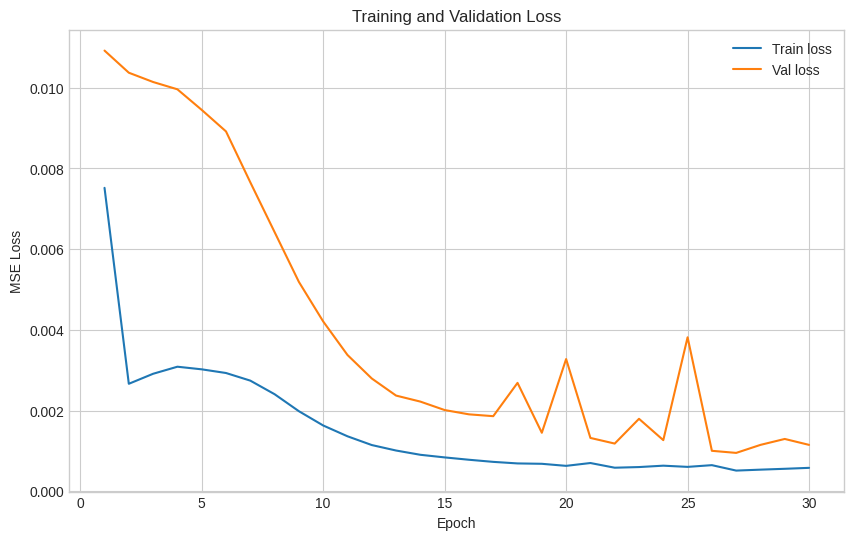

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_loss_log.keys()), list(train_loss_log.values()), label='Train loss')
plt.plot(list(val_loss_log.keys()), list(val_loss_log.values()), label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Load Model

In [ ]:
epoch = 25
model.load_state_dict(torch.load(f'{model_save_path}/lstm_{epoch}', map_location=torch.device(device)))

<ipython-input-150-990354d6f86d>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_save_path}/lstm_{epoch}', map_location=torch.devi

<All keys matched successfully>

## Estimation

In [ ]:
test_data = yf.download(tickers='EURUSD=X', start='2020-01-01', end='2023-12-31', interval='1d')
test_data.columns = test_data.columns.droplevel(1)
test_data = test_data[['Close']]
test_data

[*********************100%***********************]  1 of 1 completed


Price,Close
Date,
2020-01-01,1.122083
2020-01-02,1.122083
2020-01-03,1.117144
2020-01-06,1.116196
2020-01-07,1.119799
...,...
2023-12-25,1.102657
2023-12-26,1.102026
2023-12-27,1.104301


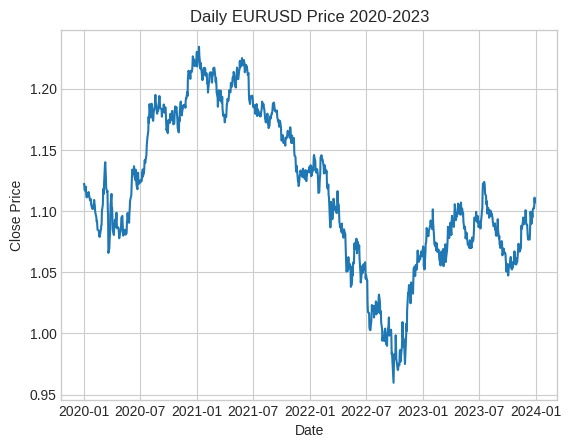

In [ ]:
plt.plot(test_data.index, test_data.Close)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Daily EURUSD Price 2020-2023')
plt.show()

In [ ]:
test_dataset, scaler = process_sequence_data(test_data, look_back=look_back, scaler=scaler, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# make predictions
y_pred_log = []
y_log = []

model.eval()
for batch, data in enumerate(test_loader):
  X_test, y_test = data
  X_test = X_test.to(device)
  y_test = y_test.to(device)

  y_test_pred = model(X_test)
  y_test_pred = y_test_pred.view(-1,1)
  # import pdb; pdb.set_trace()
  loss = criterion(y_test_pred, y_test)

  # invert predictions
  y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy()).item()
  y_test = scaler.inverse_transform(y_test.detach().numpy()).item()

  y_pred_log.append(y_test_pred)
  y_log.append(y_test)

In [ ]:
# compute root mean squared error, mean_absolute_error
test_rmse = math.sqrt(mean_squared_error(y_log, y_pred_log))
print(f'Test Root Mean Squared Error: {test_rmse:.4f}')
test_mae = mean_absolute_error(y_log, y_pred_log)
print(f'Test Mean Absolute Error: {test_mae: .4f}')

Test Root Mean Squared Error: 0.0530
Test Mean Absolute Error:  0.0427


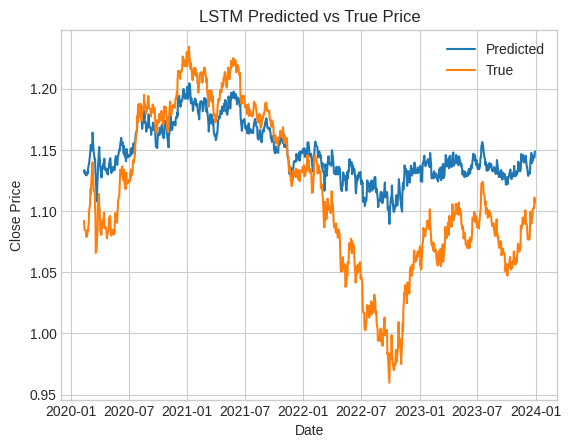

In [ ]:
plt.plot(test_data.index[look_back:], y_pred_log, label='Predicted')
plt.plot(test_data.index[look_back:], y_log, label='True')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('LSTM Predicted vs True Price')
plt.legend()
plt.show()

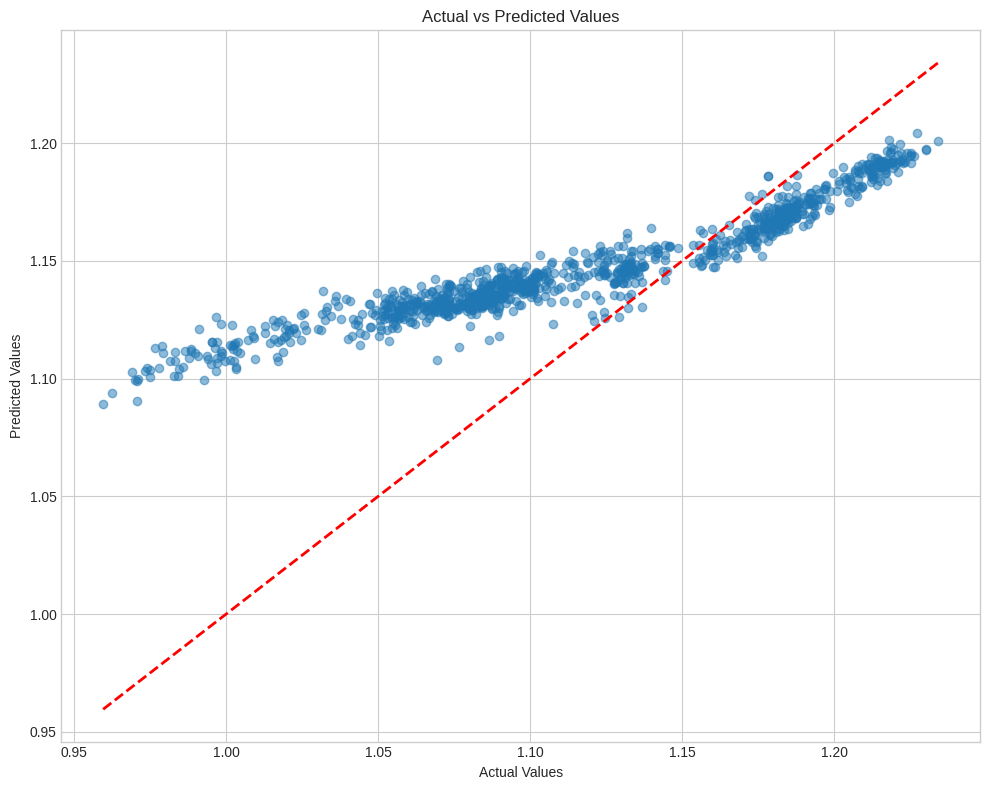

In [ ]:
y_pred = np.array(y_pred_log)
y_actual = np.array(y_log)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()


# LSTM model with two feature inputs

The EURUSD daily close price is not sufficient to predict price movement. Now try to build a model with two features (EURUSD and S&P500 daily close price)

In [16]:
tickers = {'ticker_name': ['EURUSD', 'S&P500'],
           'ticker': ['EURUSD=X', '^SPX']}

price_datasets = yf.download(tickers=tickers['ticker'], start='2011-12-31', end='2019-12-31', interval='1d')
df_price = price_datasets[['Close']]
df_price.columns = df_price.columns.droplevel(1)
df_price.columns = tickers['ticker_name']
df_price.head()

[*********************100%***********************]  2 of 2 completed


,EURUSD,S&P500
Date,,
2012-01-02,1.296008,NaN
2012-01-03,1.294096,1277.060059
2012-01-04,1.305602,1277.300049
2012-01-05,1.293142,1281.060059
2012-01-06,1.279607,1277.810059


In [17]:
# nan handling
df_price.isna().sum()

,0
EURUSD,5
S&P500,75


In [18]:
# fill na values with the last valid obsrvation
df_price.ffill(inplace=True)
# remove the first row where no valid observation is available to fill
df_price = df_price.iloc[1:,:]
df_price.head()

<ipython-input-18-a5850bd7c336>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_price.ffill(inplace=True)


,EURUSD,S&P500
Date,,
2012-01-03,1.294096,1277.060059
2012-01-04,1.305602,1277.300049
2012-01-05,1.293142,1281.060059
2012-01-06,1.279607,1277.810059
2012-01-09,1.268038,1280.699951


In [19]:
df_price[df_price.isna().any(axis=1)]

,EURUSD,S&P500
Date,,


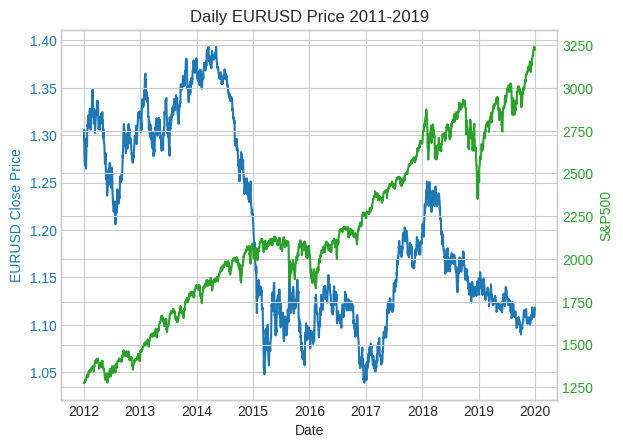

In [77]:
fig, ax1 = plt.subplots()

ax1.plot(df_price.index, df_price.EURUSD, 'tab:blue', label='EURUSD')
ax1.set_xlabel('Date')
ax1.set_ylabel('EURUSD Close Price', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')

ax2 = ax1.twinx()

ax2.plot(df_price.index, df_price['S&P500'], 'tab:green', label='S&P500')
ax2.set_ylabel('S&P500', color='tab:green')
ax2.tick_params('y', colors='tab:green')

plt.title('Daily EURUSD Price 2011-2019')
plt.show()

train_loss has not change while val loss lower and lower -> overfitting??

* dropout
* reduce hidden_layer -> 32
* reduce learning rate -> 0.0001
* add weight_decay

In [178]:
def train_two_features(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path):
  train_loss_log = {}
  val_loss_log = {}
  best_val_loss = np.inf

  for epoch in range(1, epochs+1):

    # model training
    model.train()
    train_loss = 0
    for batch, data in tqdm(enumerate(train_loader), total=len(train_loader), desc="Training", leave=False):
      X, y = data
      X = X.to(device)
      y = y.to(device)

      optimizer.zero_grad()

      y_pred = model(X)
      loss = criterion(y_pred, y[:,0]) # yl[1,2] -> [1,1] only eur value for loss

      loss.backward()
      optimizer.step()

      train_loss += loss.item()

    # model validation
    model.eval()
    val_loss = 0

    for batch, data in tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation", leave=False):
      X_val, y_val = data
      X_val = X_val.to(device)
      y_val = y_val.to(device)

      y_val_pred = model(X_val)
      loss = criterion(y_val_pred, y_val[:,0]) # y_val[1,2] -> [1,1] only eur value for loss

      val_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_log[epoch] = avg_train_loss
    avg_val_loss = val_loss / len(val_loader)
    val_loss_log[epoch] = avg_val_loss
    print(f'Epoch: {epoch}/{epochs}, Train loss: {avg_train_loss: .6f}, Val Loss: {avg_val_loss:.6f}')

    # import pdb; pdb.set_trace()

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss

      # save model
      torch.save(model.state_dict(), f'{model_save_path}/lstm_{epoch}')
      print(f'Model saved with validation loss: {best_val_loss:.6f}')

    print('-'*60)

  return train_loss_log, val_loss_log

In [182]:
# data set
train_size = 0.7

# data split

train_data, val_data = Utils.data_split(df_price, train_size)

# hyperparameters
look_back = 30
scaler = MinMaxScaler(feature_range=(-1,1))
batch_size = 1

learning_rate = 0.0005

epochs = 50
input_size = 2
hidden_size = 32
num_layers = 1
output_size = 1
dropout = 0
model_save_path = '.'

# data processing
train_dataset, scaler = process_sequence_data(train_data, look_back=look_back, scaler=scaler, train=True)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset, scaler = process_sequence_data(val_data, look_back=look_back, scaler=scaler, train=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

model = LSTM(input_size=input_size, hidden_size= hidden_size, num_layers= num_layers, output_size= output_size, dropout=dropout)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

start_time = time.time()
train_loss_log, val_loss_log = train_two_features(model, train_loader, val_loader, optimizer, criterion, epochs, model_save_path=model_save_path)
end_time = time.time()

print('')
print(f'Time to complete {end_time-start_time:.2f} sec')

Epoch: 1/50, Train loss:  0.012267, Val Loss: 0.045238
Model saved with validation loss: 0.045238
------------------------------------------------------------


Epoch: 2/50, Train loss:  0.009103, Val Loss: 0.044082
Model saved with validation loss: 0.044082
------------------------------------------------------------


Epoch: 3/50, Train loss:  0.007349, Val Loss: 0.042598
Model saved with validation loss: 0.042598
------------------------------------------------------------


Epoch: 4/50, Train loss:  0.006942, Val Loss: 0.040858
Model saved with validation loss: 0.040858
------------------------------------------------------------


Epoch: 5/50, Train loss:  0.006281, Val Loss: 0.039031
Model saved with validation loss: 0.039031
------------------------------------------------------------


Epoch: 6/50, Train loss:  0.005451, Val Loss: 0.038139
Model saved with validation loss: 0.038139
------------------------------------------------------------


Epoch: 7/50, Train loss:  0.004593, Val Loss: 0.039087
------------------------------------------------------------


Epoch: 8/50, Train loss:  0.003747, Val Loss: 0.042696
------------------------------------------------------------


Epoch: 9/50, Train loss:  0.003043, Val Loss: 0.047761
------------------------------------------------------------


Epoch: 10/50, Train loss:  0.002474, Val Loss: 0.049163
------------------------------------------------------------


Epoch: 11/50, Train loss:  0.002128, Val Loss: 0.046170
------------------------------------------------------------


Epoch: 12/50, Train loss:  0.001930, Val Loss: 0.039346
------------------------------------------------------------


Epoch: 13/50, Train loss:  0.001859, Val Loss: 0.032904
Model saved with validation loss: 0.032904
------------------------------------------------------------


Epoch: 14/50, Train loss:  0.001809, Val Loss: 0.027656
Model saved with validation loss: 0.027656
------------------------------------------------------------


Epoch: 15/50, Train loss:  0.001774, Val Loss: 0.023595
Model saved with validation loss: 0.023595
------------------------------------------------------------


Epoch: 16/50, Train loss:  0.001751, Val Loss: 0.020799
Model saved with validation loss: 0.020799
------------------------------------------------------------


Epoch: 17/50, Train loss:  0.001724, Val Loss: 0.020249
Model saved with validation loss: 0.020249
------------------------------------------------------------


Epoch: 18/50, Train loss:  0.001695, Val Loss: 0.020023
Model saved with validation loss: 0.020023
------------------------------------------------------------


Epoch: 19/50, Train loss:  0.001665, Val Loss: 0.019807
Model saved with validation loss: 0.019807
------------------------------------------------------------


Epoch: 20/50, Train loss:  0.001644, Val Loss: 0.019611
Model saved with validation loss: 0.019611
------------------------------------------------------------


Epoch: 21/50, Train loss:  0.001637, Val Loss: 0.016284
Model saved with validation loss: 0.016284
------------------------------------------------------------


Epoch: 22/50, Train loss:  0.001618, Val Loss: 0.018085
------------------------------------------------------------


Epoch: 23/50, Train loss:  0.001603, Val Loss: 0.015908
Model saved with validation loss: 0.015908
------------------------------------------------------------


Epoch: 24/50, Train loss:  0.001585, Val Loss: 0.017938
------------------------------------------------------------


Epoch: 25/50, Train loss:  0.001576, Val Loss: 0.019003
------------------------------------------------------------


Epoch: 26/50, Train loss:  0.001575, Val Loss: 0.013210
Model saved with validation loss: 0.013210
------------------------------------------------------------


Epoch: 27/50, Train loss:  0.001584, Val Loss: 0.013072
Model saved with validation loss: 0.013072
------------------------------------------------------------


Epoch: 28/50, Train loss:  0.001575, Val Loss: 0.013046
Model saved with validation loss: 0.013046
------------------------------------------------------------


Epoch: 29/50, Train loss:  0.001572, Val Loss: 0.012957
Model saved with validation loss: 0.012957
------------------------------------------------------------


Epoch: 30/50, Train loss:  0.001580, Val Loss: 0.012005
Model saved with validation loss: 0.012005
------------------------------------------------------------


Epoch: 31/50, Train loss:  0.001559, Val Loss: 0.005676
Model saved with validation loss: 0.005676
------------------------------------------------------------


Epoch: 32/50, Train loss:  0.001561, Val Loss: 0.018147
------------------------------------------------------------


Epoch: 33/50, Train loss:  0.001522, Val Loss: 0.011124
------------------------------------------------------------


Epoch: 34/50, Train loss:  0.001612, Val Loss: 0.021894
------------------------------------------------------------


Epoch: 35/50, Train loss:  0.001482, Val Loss: 0.012755
------------------------------------------------------------


Epoch: 36/50, Train loss:  0.001472, Val Loss: 0.014328
------------------------------------------------------------


Epoch: 37/50, Train loss:  0.001479, Val Loss: 0.016034
------------------------------------------------------------


Epoch: 38/50, Train loss:  0.001522, Val Loss: 0.015524
------------------------------------------------------------


Epoch: 39/50, Train loss:  0.001519, Val Loss: 0.014511
------------------------------------------------------------


Epoch: 40/50, Train loss:  0.001511, Val Loss: 0.017110
------------------------------------------------------------


Epoch: 41/50, Train loss:  0.001524, Val Loss: 0.006322
------------------------------------------------------------


Epoch: 42/50, Train loss:  0.001560, Val Loss: 0.029291
------------------------------------------------------------


Epoch: 43/50, Train loss:  0.001512, Val Loss: 0.003930
Model saved with validation loss: 0.003930
------------------------------------------------------------


Epoch: 44/50, Train loss:  0.001581, Val Loss: 0.021929
------------------------------------------------------------


Epoch: 45/50, Train loss:  0.001530, Val Loss: 0.012959
------------------------------------------------------------


Epoch: 46/50, Train loss:  0.001620, Val Loss: 0.029530
------------------------------------------------------------


Epoch: 47/50, Train loss:  0.001527, Val Loss: 0.011724
------------------------------------------------------------


Epoch: 48/50, Train loss:  0.001562, Val Loss: 0.008507
------------------------------------------------------------


Epoch: 49/50, Train loss:  0.001654, Val Loss: 0.023863
------------------------------------------------------------


Epoch: 50/50, Train loss:  0.001584, Val Loss: 0.018636
------------------------------------------------------------

Time to complete 254.80 sec


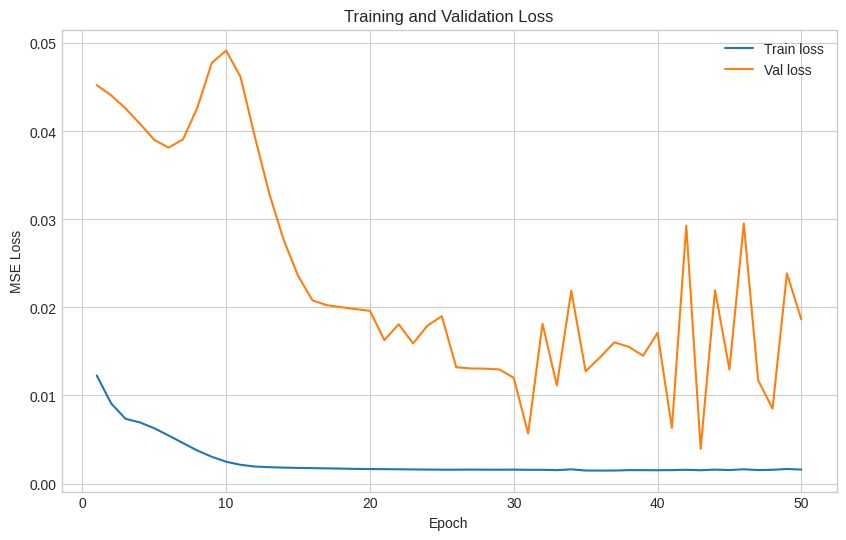

In [183]:
plt.figure(figsize=(10, 6))
plt.plot(list(train_loss_log.keys()), list(train_loss_log.values()), label='Train loss')
plt.plot(list(val_loss_log.keys()), list(val_loss_log.values()), label='Val loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Load Model

In [185]:
epoch = 31
model.load_state_dict(torch.load(f'{model_save_path}/lstm_{epoch}', map_location=torch.device(device)))

<ipython-input-185-87ca20556b66>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'{model_save_path}/lstm_{epoch}', map_location=torch.devi

<All keys matched successfully>

## Estimation

In [186]:
test_dataset = yf.download(tickers=tickers['ticker'], start='2020-01-01', end='2023-12-31', interval='1d')
test_data = test_dataset[['Close']]
test_data.columns = test_data.columns.droplevel(1)
test_data.columns = tickers['ticker_name']
test_data.head()

[*********************100%***********************]  2 of 2 completed


,EURUSD,S&P500
Date,,
2020-01-01,1.122083,NaN
2020-01-02,1.122083,3257.850098
2020-01-03,1.117144,3234.850098
2020-01-06,1.116196,3246.280029
2020-01-07,1.119799,3237.179932


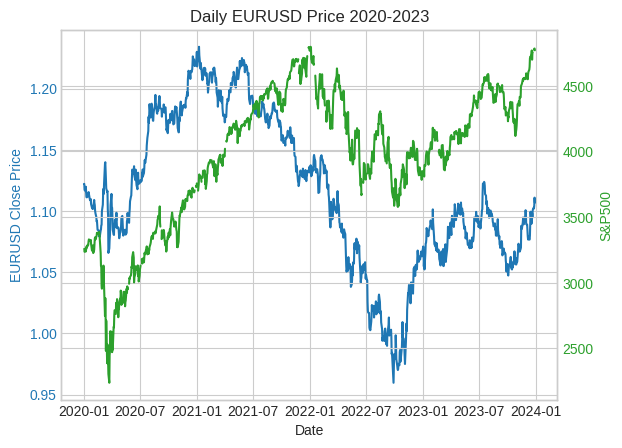

In [187]:
fig, ax1 = plt.subplots()

ax1.plot(test_data.index, test_data.EURUSD, 'tab:blue', label='EURUSD')
ax1.set_xlabel('Date')
ax1.set_ylabel('EURUSD Close Price', color='tab:blue')
ax1.tick_params('y', colors='tab:blue')

ax2 = ax1.twinx()

ax2.plot(test_data.index, test_data['S&P500'], 'tab:green', label='S&P500')
ax2.set_ylabel('S&P500', color='tab:green')
ax2.tick_params('y', colors='tab:green')

plt.title('Daily EURUSD Price 2020-2023')
plt.show()

In [188]:
# nan handling
print(test_data.isna().sum())

# fill na values with the last valid obsrvation
test_data.ffill(inplace=True)

print(f'NaN count after forward na filling: \n{test_data.isna().sum()}')

display(test_data.head())
test_data = test_data.iloc[1:, :] # remove the first row containing nan

EURUSD     0
S&P500    37
dtype: int64
NaN count after forward na filling: 
EURUSD    0
S&P500    1
dtype: int64


<ipython-input-188-508f5121f760>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.ffill(inplace=True)


,EURUSD,S&P500
Date,,
2020-01-01,1.122083,NaN
2020-01-02,1.122083,3257.850098
2020-01-03,1.117144,3234.850098
2020-01-06,1.116196,3246.280029
2020-01-07,1.119799,3237.179932


In [189]:
test_dataset, scaler = process_sequence_data(test_data, look_back=look_back, scaler=scaler, train=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [190]:
df_price.iloc[:,0:1]

,EURUSD
Date,
2012-01-03,1.294096
2012-01-04,1.305602
2012-01-05,1.293142
2012-01-06,1.279607
2012-01-09,1.268038
...,...
2019-12-24,1.109385
2019-12-25,1.109016
2019-12-26,1.109545


In [196]:
# make predictions
y_pred_log = []
y_log = []

# scaler for eurusd
test_scaler = MinMaxScaler(feature_range=(-1,1))
test_scaler.fit(df_price.iloc[:,0:1]) # previous scaler expects two inputs

model.eval()
for batch, data in enumerate(test_loader):
  X_test, y_test = data
  X_test = X_test.to(device)
  y_test = y_test.to(device)

  y_test_pred = model(X_test)

  # import pdb; pdb.set_trace()

  # invert predictions
  y_test_pred = test_scaler.inverse_transform(y_test_pred.view(-1,1).detach().numpy()).item() # torch.Size[1] -> [1,1]
  y_test = test_scaler.inverse_transform(y_test[:,0].view(-1,1).detach().numpy()).item() # torch.Size[1,2] -> [1,1]

  y_pred_log.append(y_test_pred)
  y_log.append(y_test)

In [197]:
# compute root mean squared error, mean_absolute_error
test_rmse = math.sqrt(mean_squared_error(y_log, y_pred_log))
print(f'Test Root Mean Squared Error: {test_rmse:.4f}')
test_mae = mean_absolute_error(y_log, y_pred_log)
print(f'Test Mean Absolute Error: {test_mae: .4f}')

Test Root Mean Squared Error: 0.0421
Test Mean Absolute Error:  0.0378


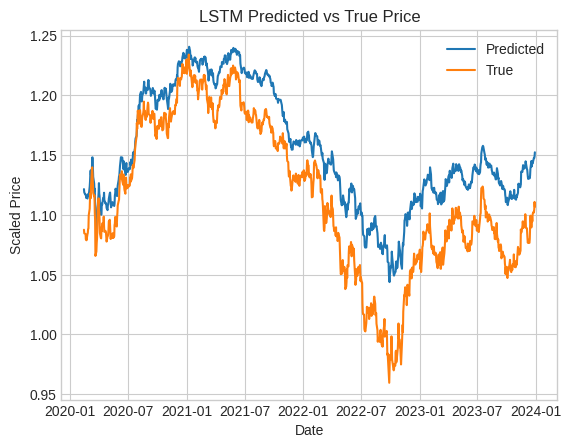

In [199]:
plt.plot(test_data.index[look_back:], y_pred_log, label='Predicted')
plt.plot(test_data.index[look_back:], y_log, label='True')
plt.xlabel('Date')
plt.ylabel('Scaled Price')
plt.title('LSTM Predicted vs True Price')
plt.legend()
plt.show()

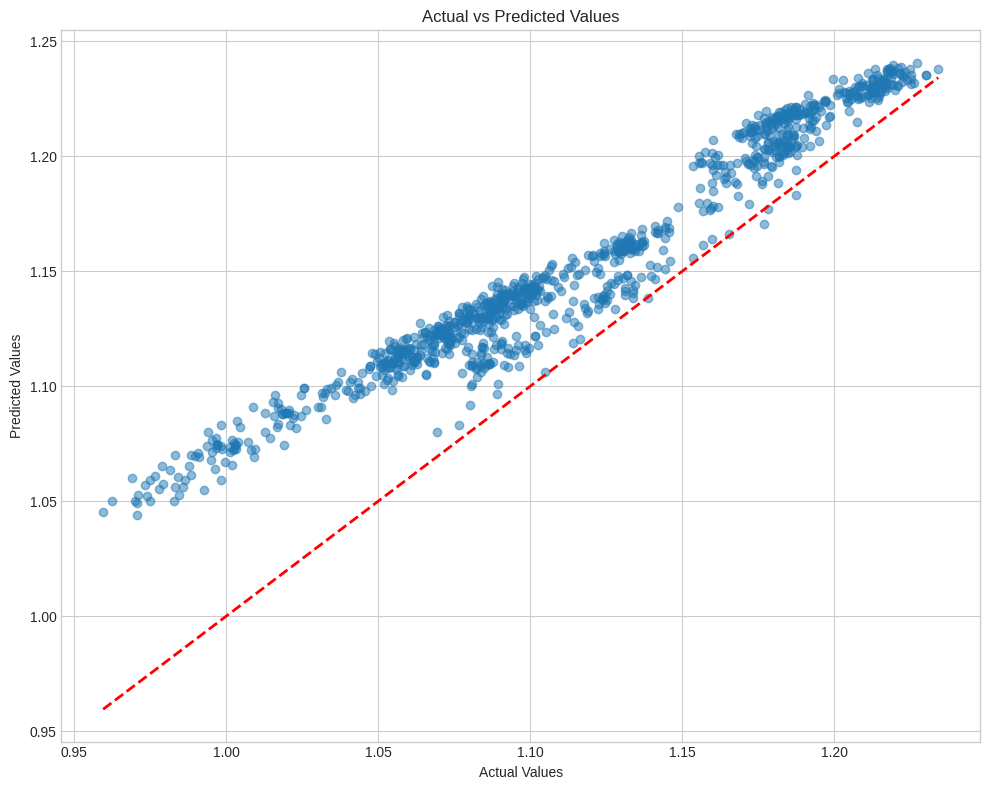

In [200]:
y_pred = np.array(y_pred_log)
y_actual = np.array(y_log)

# Create a scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_actual, y_pred, alpha=0.5)
plt.plot([y_actual.min(), y_actual.max()], [y_actual.min(), y_actual.max()], 'r--', lw=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.show()


Generally, this two feature model can capture the price movement pattern but it is tendency to overestimate price movement.